## List

1. 64360612 กิติพงษ์ สายยศ
2. 64362968 ธิติพล แพ่งเมือง
3. 64366584 สุปกาณฑ์ อ่วมวงษ์
4. 64366744 สุวัชชัย พิณเนียม
5. 64365570 วัชระพงศ์ รอดพงษ์

### NaiveBayes

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from scipy.fftpack import dct
from sklearn.metrics import accuracy_score
import seaborn as sns

#### Load the MNITS digits Data set using tensorflow

In [24]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

#### Model with no Features Engineering

In [25]:
x_train = x_train.reshape(-1, 28 * 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype('float32') / 255.0
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Naive Bayes on DCT features: {accuracy:.2f}')

Accuracy of Naive Bayes on DCT features: 0.56


#### Normalize feature dataset and Feature Engineering
- normalize pixel values
- Discrete Cosine Transform

In [26]:
def apply_dct(images):
    dct_features = []
    for image in images:
        dct_image = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')
        dct_features.append(dct_image.flatten())
    return np.array(dct_features)

In [27]:
# Reshape from 3D Array to 2D Array
x_train = x_train.reshape(-1, 28 , 28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28 , 28).astype('float32') / 255.0
x_train = apply_dct(x_train)
x_test = apply_dct(x_test)

## Guassian Naive Bayes Model

In [28]:
model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

## Confusion Matrix

In [29]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Naive Bayes on DCT features: {accuracy:.2f}')

Accuracy of Naive Bayes on DCT features: 0.84


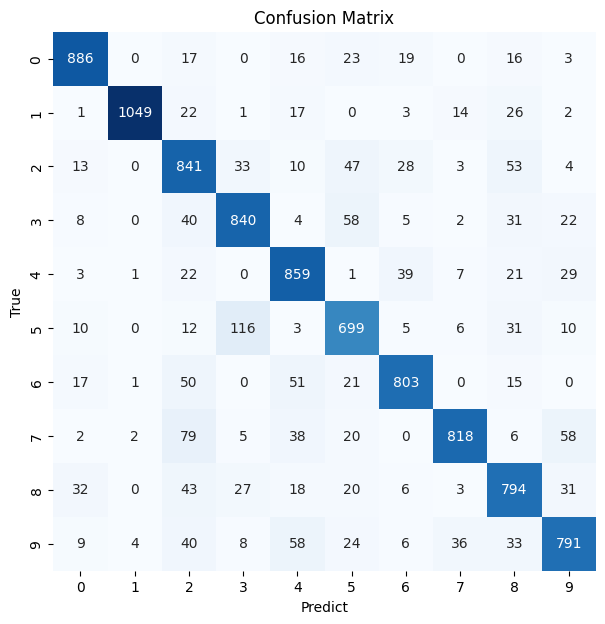

In [31]:
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Evaluation
- Precision
- Recall
- F1-Score
- Accuracy

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

precision_ = precision_score(y_test, y_pred, average='weighted')
recall_ = recall_score(y_test, y_pred, average='weighted')
f1_ = f1_score(y_test, y_pred, average='weighted')

accuracy_ = accuracy_score(y_test, y_pred)

_metrics = {
    'Precision': precision_,
    'Recall': recall_,
    'F1-Score': f1_,
    'Accuracy': accuracy_
}

df_matrix = pd.DataFrame([_metrics])
print("Classification Report")
df_matrix

Classification Report


,Precision,Recall,F1-Score,Accuracy
0,0.842932,0.838,0.839216,0.838


## Hyperparameter Tuning

การเพิ่มค่าคงที่ขนาดเล็ก smoothing parameter หรือ smoothing constant ให้กับความแปรปรวนของข้อมูลแต่ละคลาสเพื่อแก้ปัญหาความแปรปรวนต่ำหรือเป็นศูนย์

In [33]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gridSearch_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=3,
                     verbose=1, 
                     scoring='accuracy')

gridSearch_NB.fit(x_test, y_test);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [34]:
print("Best Parameter: ", gridSearch_NB.best_params_)
print("Best Score: ", gridSearch_NB.best_score_)

Best Parameter:  {'var_smoothing': 0.01519911082952933}
Best Score:  0.8383031164544169


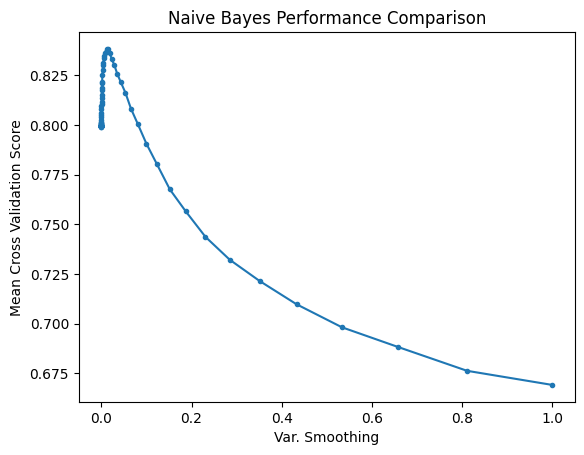

In [35]:
results_NB = pd.DataFrame(gridSearch_NB.cv_results_['params'])
results_NB['test_score'] = gridSearch_NB.cv_results_['mean_test_score']

plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean Cross Validation Score")
plt.title("Naive Bayes Performance Comparison")
plt.show()

In [36]:
best_model = gridSearch_NB.best_estimator_  # Best model
predict_test = best_model.predict(x_test)

accuracy_test = accuracy_score(y_test, predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.8655


#### Confusion Matrix หลังปรับ var smooth

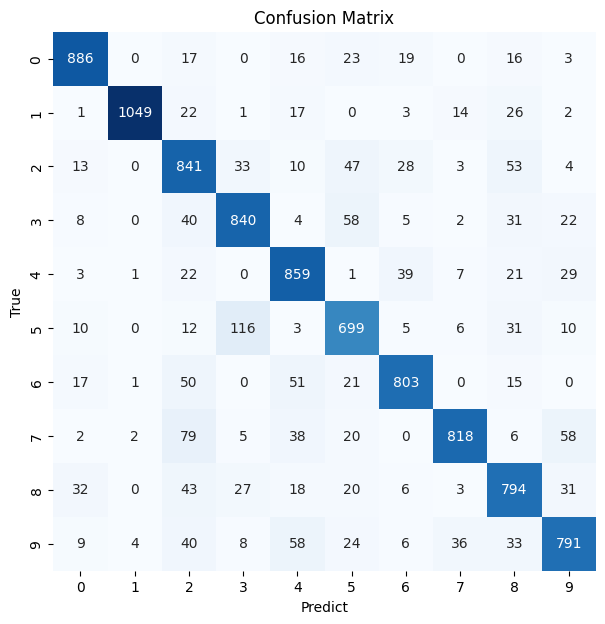

In [37]:
confusm = tf.math.confusion_matrix(y_test, predict_test)

plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Evaluation

In [38]:
precision_1 = precision_score(y_test, predict_test, average='weighted')
recall_1 = recall_score(y_test, predict_test, average='weighted')
f1_1 = f1_score(y_test, predict_test, average='weighted')

accuracy_1 = accuracy_score(y_test, predict_test)

_metrics1 = {
    'Precision': precision_1,
    'Recall': recall_1,
    'F1-Score': f1_1,
    'Accuracy': accuracy_1
}

df_matrix1 = pd.DataFrame([_metrics1])

df_matrix1

,Precision,Recall,F1-Score,Accuracy
0,0.870607,0.8655,0.86458,0.8655


#### แสดงรูปที่ทายถูก หรือ ทายผิด

In [39]:
def display_one_prediction(images, true_labels, pred_labels):
    correct = np.where(true_labels == pred_labels)[0]
    incorrect = np.where(true_labels != pred_labels)[0]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    if len(correct) > 0:
        random_correct = np.random.choice(correct)
        axs[0].imshow(images[random_correct].reshape(28, 28), cmap='gray')
        axs[0].set_title(f"Correct\nPred: {pred_labels[random_correct]}, True: {true_labels[random_correct]}")
    else:
        axs[0].axis('off')

    if len(incorrect) > 0:
        random_incorrect = np.random.choice(incorrect)
        axs[1].imshow(images[random_incorrect].reshape(28, 28), cmap='gray')
        axs[1].set_title(f"Incorrect\nPred: {pred_labels[random_incorrect]}, True: {true_labels[random_incorrect]}")
    else:
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# invert discrete cosine transform
from scipy.fftpack import idct

def apply_idct(dct_images):
    idct_features = []
    for dct_image in dct_images:
        idct_image = idct(idct(dct_image.reshape(28, 28), axis=1, norm='ortho'), axis=0, norm='ortho')
        idct_features.append(idct_image)
    return np.array(idct_features)

In [40]:
x_test_inverted = apply_idct(x_test)
x_test_reshaped_inverted = x_test_inverted.reshape(-1, 28, 28)

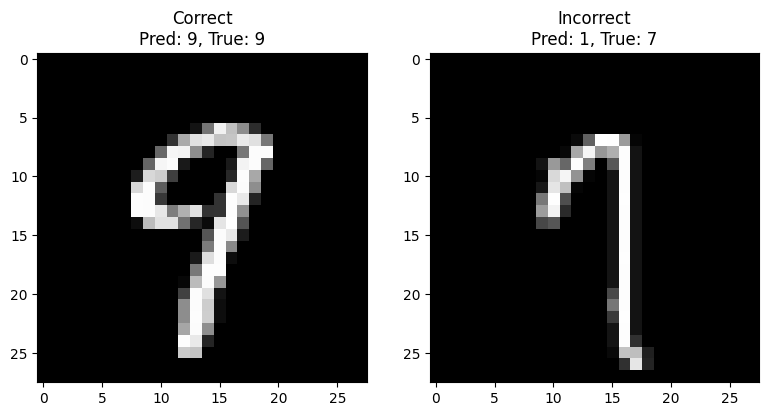

In [45]:
# Display Image that Predicted correct and Incorrect...
display_one_prediction(x_test_reshaped_inverted, y_test, predict_test)

#### Compare between before and after hyperparameter Tuning

In [42]:
print("\nBefore Tuning...")
print(df_matrix)
print("\n----------------------------------------------------\n")
print("After Tuning...")
print(df_matrix1)


Before Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.842932   0.838  0.839216     0.838

----------------------------------------------------

After Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.870607  0.8655   0.86458    0.8655


### Classification Report

In [43]:
from sklearn.metrics import classification_report

report_nb = classification_report(y_test, predict_test)
print("Classification Report for Naive Bayes Model:\n", report_nb)

Classification Report for Naive Bayes Model:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       980
           1       0.85      0.99      0.91      1135
           2       0.87      0.85      0.86      1032
           3       0.82      0.87      0.85      1010
           4       0.88      0.91      0.89       982
           5       0.78      0.83      0.80       892
           6       0.93      0.90      0.91       958
           7       0.79      0.91      0.85      1028
           8       0.94      0.70      0.81       974
           9       0.90      0.76      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.86     10000



In [44]:
# Save model
import joblib

joblib.dump(best_model, 'model/nb_mnist_model.pkl')

['model/nb_mnist_model.pkl']